In [ ]:
# Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Downloading
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   154M      0  0:00:05  0:00:05 --:--:--  167M
 drive			      'MSR-LA - 3467.docx'  'readme[1].txt'
 kagglecatsanddogs_3367a.zip   PetImages	     sample_data


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import json

In [ ]:
with open('data_22.03.2022.json') as json_file:
    data = json.load(json_file)
    # print(data)

In [ ]:
uniquer = ['']
for el, idx in enumerate(data['fonts'][:900]):
  # serif = 'С засечками' if idx['category'] == 'serif' else 'Без засечек'
  # if idx['category'] != 'sans-serif' and idx['category'] != 'serif':
  #   print(el, idx['family'], idx['category'], serif, 'Alarm')
  #   break
  # print(el, idx['family'], idx['category'], serif)
  if idx['category'] in uniquer:
    continue
  uniquer.append(str(idx['category']))
print(uniquer)

['', 'sans-serif', 'serif', 'display', 'handwriting', 'monospace']


In [ ]:
data['fonts']

In [ ]:
uniquer = ['']
for el, idx in enumerate(data['fonts'][:900]):
  # serif = 'С засечками' if idx['category'] == 'serif' else 'Без засечек'
  # if idx['category'] != 'sans-serif' and idx['category'] != 'serif':
  #   print(el, idx['family'], idx['category'], serif, 'Alarm')
  #   break
  # print(el, idx['family'], idx['category'], serif)
  if idx['category'] in uniquer:
    continue
  uniquer.append(str(idx['category']))
print(uniquer)

In [ ]:
catalog = '/content/drive/MyDrive/colabData/fontData/data/img'

In [ ]:
import os

num_skipped = 0
for folder_name in ("sans serif", "serif"):
    folder_path = os.path.join(catalog, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (50, 200)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    catalog,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    catalog,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7852 files belonging to 4 classes.
Using 6282 files for training.
Found 7852 files belonging to 4 classes.
Using 1570 files for validation.


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 50, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test = list(train_ds.as_numpy_iterator()) 

In [ ]:
print(test[1])

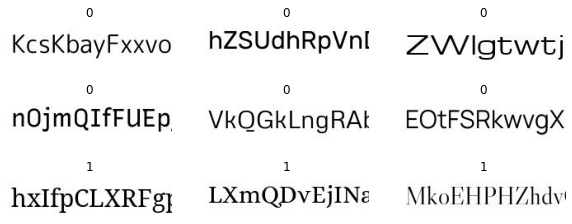

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

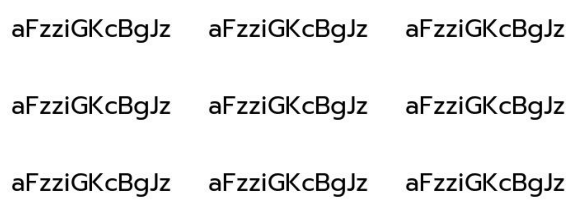

In [ ]:
plt.figure(figsize=(10, 4))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

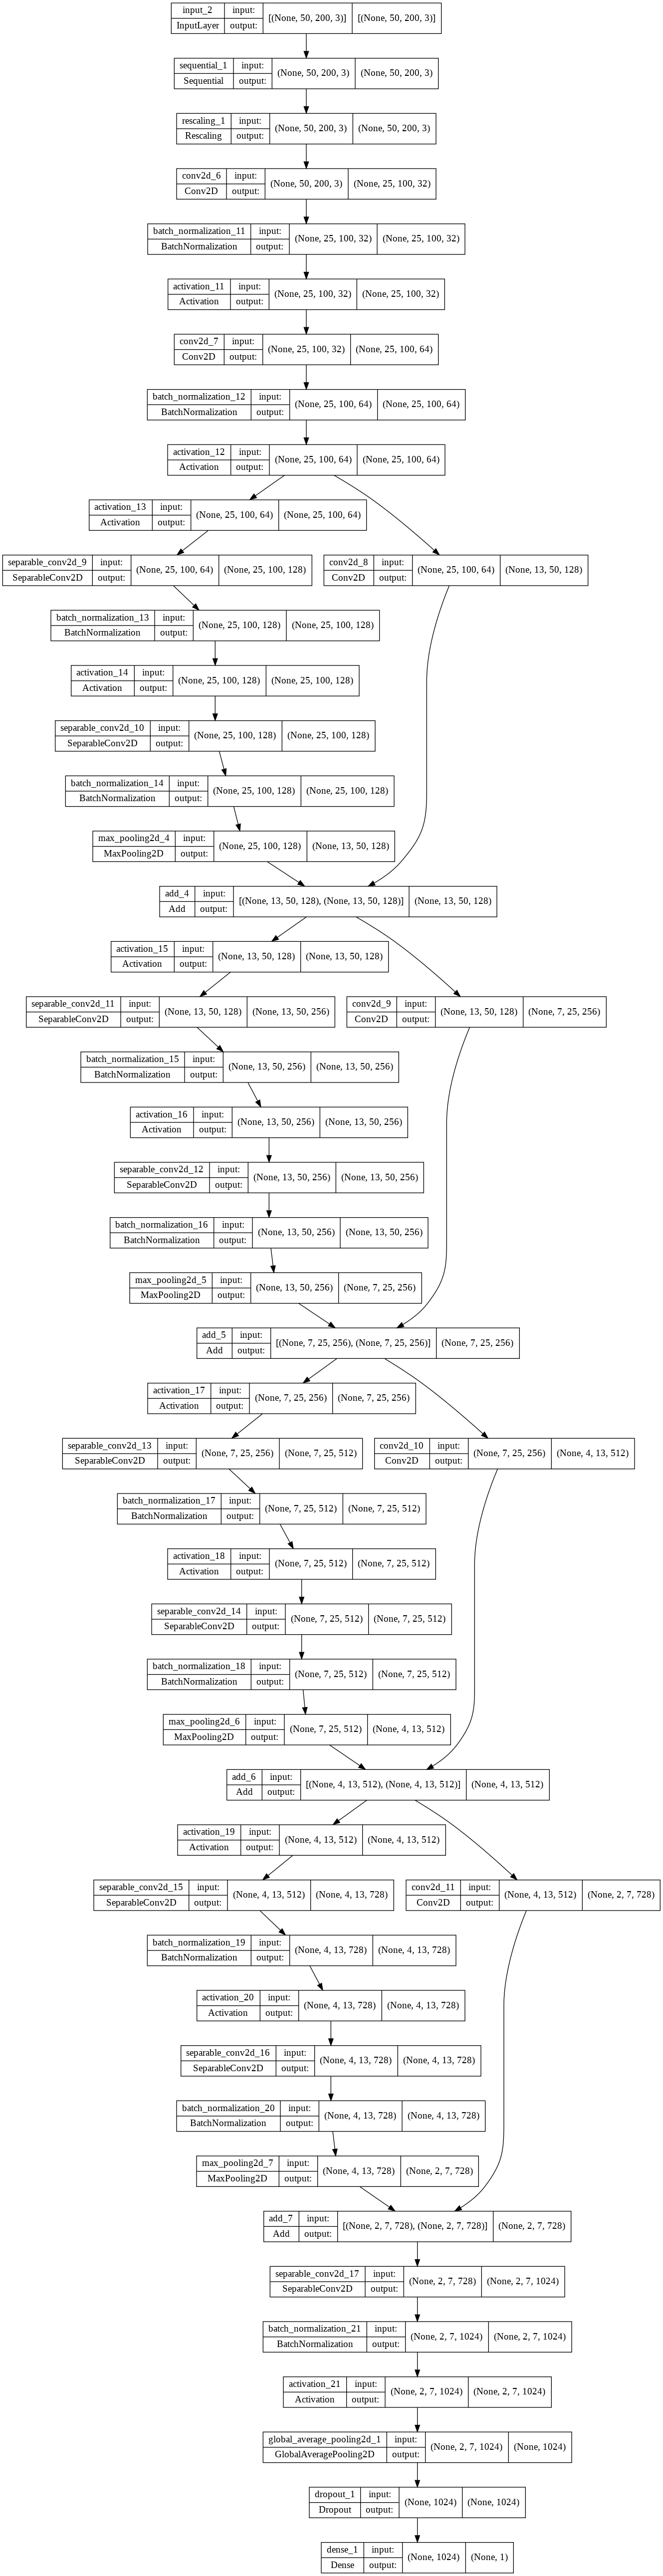

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
197/197 [==============================] - 52s 250ms/step - loss: 0.3399 - accuracy: 0.8542 - val_loss: 0.9372 - val_accuracy: 0.4121
Epoch 2/50
197/197 [==============================] - 46s 231ms/step - loss: 0.1403 - accuracy: 0.9489 - val_loss: 4.5927 - val_accuracy: 0.4121
Epoch 3/50
197/197 [==============================] - 46s 231ms/step - loss: 0.1090 - accuracy: 0.9586 - val_loss: 2.7610 - val_accuracy: 0.5904
Epoch 4/50
 91/197 [============>.................] - ETA: 22s - loss: 0.1088 - accuracy: 0.9533

KeyboardInterrupt: ignored

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

FileNotFoundError: ignored